In [1]:
MAX_TIME = 1
INIT_SIZE = 5
DEVICE = "cpu" # "cuda:0"

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '11-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'11-torch_bartz09_1min_5init_2023-05-13_21-46-17'

# Chapter 11: Sequential Parameter Optimization
## Hyperparameter Tuning: pytorch with fashionMNIST Data Using Hold-out Data Sets

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython               0.0.70
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


In [5]:
from tabulate import tabulate
import copy
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from functools import partial
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_values,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
)

from spotPython.torch.traintest import evaluate_cv, evaluate_hold_out
from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values

from spotPython.utils.convert import get_Xy_from_df
from spotPython.utils.init import fun_control_init
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch

warnings.filterwarnings("ignore")

# Neural Net specific imports:
from spotPython.torch.netfashionMNIST import Net_fashionMNIST

In [6]:
print(torch.__version__)
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS device: ", mps_device)

2.0.1
MPS device:  mps


## 0. Initialization of the Empty `fun_control` Dictionary

In [7]:
fun_control = fun_control_init()

## 1. Load fashionMNIST Data

In [8]:
def load_data(data_dir="./data"):
    # Download training data from open datasets.
    training_data = datasets.FashionMNIST(
        root=data_dir,
        train=True,
        download=True,
        transform=ToTensor(),
    )
    # Download test data from open datasets.
    test_data = datasets.FashionMNIST(
        root=data_dir,
        train=False,
        download=True,
        transform=ToTensor(),
    )
    return training_data, test_data

In [9]:
train, test = load_data()
train.data.shape, test.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [10]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})

## 2. Specification of the Preprocessing Model

In [11]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )
prep_model = None
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

`spotPython` implements a class which is similar to the class described in the PyTorch tutorial. The class is called `Net_fashionMNIST`  and is implemented in the file `netcifar10.py`. The class is imported here.

Note: In addition to the class Net from the PyTorch tutorial, the class Net_CIFAR10 has additional attributes, namely:

* learning rate (`lr`),
* batchsize (`batch_size`),
* epochs (`epochs`), and
* k_folds (`k_folds`).

Further attributes can be easily added to the class, e.g., `optimizer` or `loss_function`.

In [12]:
core_model = Net_fashionMNIST
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

### Modify hyperparameter of type factor

In [13]:
# fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])
# fun_control["core_model_hyper_dict"]

### Modify hyperparameter of type numeric and integer (boolean)

In [14]:
# fun_control = modify_hyper_parameter_bounds(fun_control, "delta", bounds=[1e-10, 1e-6])
# fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_split", bounds=[3, 20])
#fun_control = modify_hyper_parameter_bounds(fun_control, "merit_preprune", bounds=[0, 0])
# fun_control["core_model_hyper_dict"]
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[0, 0])
fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[2, 2])

## 5. Selection of the Objective (Loss) Function

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

**Important**:

* `spotPython` performs minimization by default.
* If accuracy should be maximized, then the objective function has to be multiplied by -1. Therefore, `weights` is set to -1 in this case.

In [15]:
fun = HyperTorch(seed=123, log_level=50).fun_torch
weights = 1.0
shuffle = True
eval = "train_hold_out"
device = DEVICE
show_batch_interval = 100_000

fun_control.update({
                "data_dir": None,
                "checkpoint_dir": None,
                "horizon": None,
                "oml_grace_period": None,
                "weights": weights,
                "step": None,
                "log_level": 50,
                "weight_coeff": None,
                "metric": None,
                "metric_sklearn": None,
                "shuffle": shuffle,
                "eval": eval,
                "device": device,
                "show_batch_interval": show_batch_interval,
               })

In [16]:
fun_control

{'data': None,
 'train': Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 'test': Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor(),
 'n_samples': 60000,
 'target_column': None,
 'shuffle': True,
 'eval': 'train_hold_out',
 'k_folds': None,
 'device': 'cpu',
 'metric_params': {},
 'show_batch_interval': 100000,
 'path': None,
 'save_model': False,
 'prep_model': None,
 'core_model': spotPython.torch.netfashionMNIST.Net_fashionMNIST,
 'core_model_hyper_dict': {'l1': {'type': 'int',
   'default': 5,
   'transform': 'transform_power_2_int',
   'lower': 2,
   'upper': 9},
  'l2': {'type': 'int',
   'default': 5,
   'transform': 'transform_power_2_int',
   'lower': 2,
   'upper': 9},
  'lr': {'type': 'float',
   'default': 0.001,
   'transform': 'None',
   'lower': 1e-05,
   'upper': 0.01},
  'batch_si

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [17]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [18]:
print(gen_design_table(fun_control))

| name       | type   |   default |   lower |   upper | transform             |
|------------|--------|-----------|---------|---------|-----------------------|
| l1         | int    |     5     |   2     |    9    | transform_power_2_int |
| l2         | int    |     5     |   2     |    9    | transform_power_2_int |
| lr         | float  |     0.001 |   1e-05 |    0.01 | None                  |
| batch_size | int    |     4     |   1     |    4    | transform_power_2_int |
| epochs     | int    |     3     |   3     |    4    | transform_power_2_int |
| k_folds    | int    |     2     |   0     |    0    | None                  |
| patience   | int    |     5     |   2     |    2    | None                  |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [19]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[5.e+00, 5.e+00, 1.e-03, 4.e+00, 3.e+00, 2.e+00, 5.e+00]])

In [20]:
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

Epoch: 1
Loss on hold-out set: 0.5371388377385835
Accuracy on hold-out set: 0.8157916666666667
Epoch: 2
Loss on hold-out set: 0.5206326787295597
Accuracy on hold-out set: 0.8228333333333333
Epoch: 3
Loss on hold-out set: 0.43183821079685974
Accuracy on hold-out set: 0.8498333333333333
Epoch: 4
Loss on hold-out set: 0.44875337290142003
Accuracy on hold-out set: 0.8485416666666666
Epoch: 5
Loss on hold-out set: 0.4088067164334934
Accuracy on hold-out set: 0.8647083333333333
Epoch: 6
Loss on hold-out set: 0.3879037287708682
Accuracy on hold-out set: 0.8687083333333333
Epoch: 7
Loss on hold-out set: 0.45722120567347396
Accuracy on hold-out set: 0.8585
Epoch: 8
Loss on hold-out set: 0.3927750444357419
Accuracy on hold-out set: 0.8732083333333334
Early stopping at epoch 7
Returned to Spot: Validation loss: 0.3927750444357419
----------------------------------------------
Epoch: 1
Loss on hold-out set: 0.6784975514694125
Accuracy on hold-out set: 0.8201666666666667
Epoch: 2
Loss on hold-out s

### 4 Results

In [21]:
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

In [22]:
spot_tuner.y

array([0.39277504, 0.59550901, 0.46841037, 0.54123037, 0.37871502,
       0.38989112, 0.36158774])

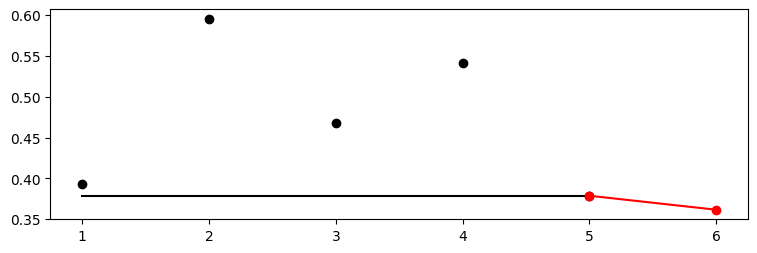

In [23]:
spot_tuner.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")



* Print the Results

In [24]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name       | type   |   default |   lower |   upper |                tuned | transform             |   importance | stars   |
|------------|--------|-----------|---------|---------|----------------------|-----------------------|--------------|---------|
| l1         | int    |       5.0 |     2.0 |     9.0 |                  9.0 | transform_power_2_int |         6.23 | *       |
| l2         | int    |       5.0 |     2.0 |     9.0 |                  8.0 | transform_power_2_int |         0.01 |         |
| lr         | float  |     0.001 |   1e-05 |    0.01 | 0.006566597192125309 | None                  |        33.79 | *       |
| batch_size | int    |       4.0 |     1.0 |     4.0 |                  4.0 | transform_power_2_int |       100.00 | ***     |
| epochs     | int    |       3.0 |     3.0 |     4.0 |                  3.0 | transform_power_2_int |         0.01 |         |
| k_folds    | int    |       2.0 |     0.0 |     0.0 |                  0.0 | None                  |  

## Show variable importance

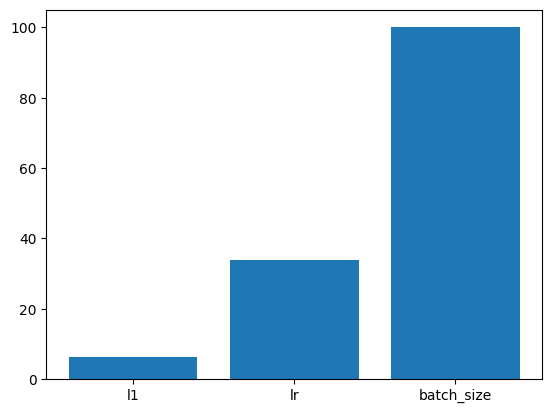

In [25]:
spot_tuner.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

In [26]:
values_default = get_default_hyperparameters_for_core_model(fun_control=fun_control)
values_default

{'l1': 32,
 'l2': 32,
 'lr': 0.001,
 'batch_size': 16,
 'epochs': 8,
 'k_folds': 2,
 'patience': 5}

In [27]:
model_default = fun_control["core_model"](**values_default)
model_default

Net_fashionMNIST(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)

## Get SPOT Results

In [28]:
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
print(X)

[[9.00000000e+00 8.00000000e+00 6.56659719e-03 4.00000000e+00
  3.00000000e+00 0.00000000e+00 2.00000000e+00]]


In [29]:
v_dict = assign_values(X, fun_control["var_name"])
return_conf_list_from_var_dict(var_dict=v_dict, fun_control=fun_control)

[{'l1': 512,
  'l2': 256,
  'lr': 0.006566597192125309,
  'batch_size': 16,
  'epochs': 8,
  'k_folds': 0,
  'patience': 2}]

In [30]:
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_fashionMNIST(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

## Test Set Accuracy

In [31]:
testset = fun_control["test"]
testset.data.shape

torch.Size([10000, 28, 28])

In [32]:
evaluate_hold_out(model_default, train_dataset = testset, shuffle=False, show_batch_interval=fun_control["show_batch_interval"])

Epoch: 1
Loss on hold-out set: 1.9690959029197692
Accuracy on hold-out set: 0.37475
Epoch: 2
Loss on hold-out set: 1.2691413729190826
Accuracy on hold-out set: 0.58275
Epoch: 3
Loss on hold-out set: 0.9935262629985809
Accuracy on hold-out set: 0.615
Epoch: 4
Loss on hold-out set: 0.8850300915241242
Accuracy on hold-out set: 0.6355
Epoch: 5
Loss on hold-out set: 0.8280074067115784
Accuracy on hold-out set: 0.6545
Epoch: 6
Loss on hold-out set: 0.7899234503507614
Accuracy on hold-out set: 0.6765
Epoch: 7
Loss on hold-out set: 0.7604604861736297
Accuracy on hold-out set: 0.6965
Epoch: 8
Loss on hold-out set: 0.7358730101585388
Accuracy on hold-out set: 0.71075
Returned to Spot: Validation loss: 0.7358730101585388
----------------------------------------------


(0.7358730101585388, nan)

In [33]:
evaluate_hold_out(model_spot, train_dataset = testset, shuffle=False, show_batch_interval=fun_control["show_batch_interval"])

Epoch: 1
Loss on hold-out set: 0.7985106372833252
Accuracy on hold-out set: 0.72025
Epoch: 2
Loss on hold-out set: 0.6703142423629761
Accuracy on hold-out set: 0.76625
Epoch: 3
Loss on hold-out set: 0.6089652180671692
Accuracy on hold-out set: 0.78675
Epoch: 4
Loss on hold-out set: 0.5773027799725533
Accuracy on hold-out set: 0.80075
Epoch: 5
Loss on hold-out set: 0.5591822902560234
Accuracy on hold-out set: 0.806
Epoch: 6
Loss on hold-out set: 0.5454326311647892
Accuracy on hold-out set: 0.81
Epoch: 7
Loss on hold-out set: 0.5356073613464832
Accuracy on hold-out set: 0.813
Epoch: 8
Loss on hold-out set: 0.5272415899634362
Accuracy on hold-out set: 0.8145
Returned to Spot: Validation loss: 0.5272415899634362
----------------------------------------------


(0.5272415899634362, nan)

In [34]:
min(spot_tuner.y), max(spot_tuner.y)

(0.3615877418983728, 0.5955090099426885)

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_tuner.y)` and
  * `max_z = max(spot_tuner.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

l1:  6.23251960463961
lr:  33.786714963710494
batch_size:  100.0


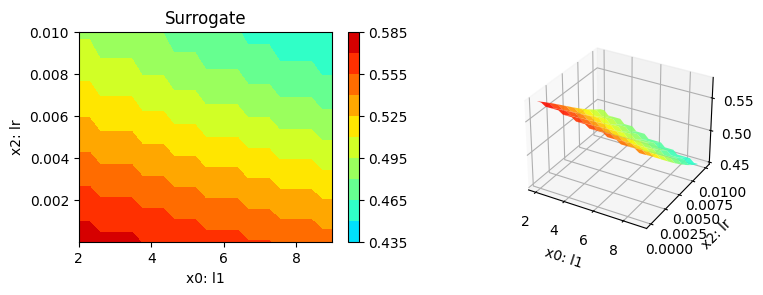

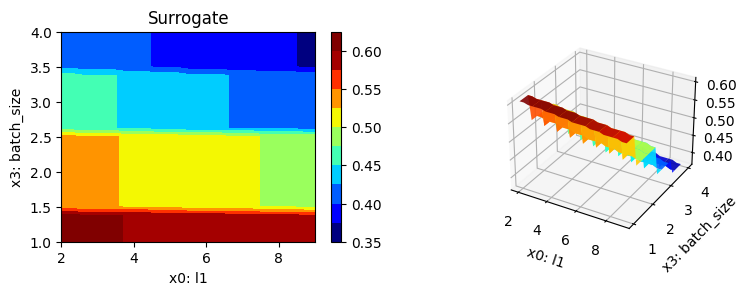

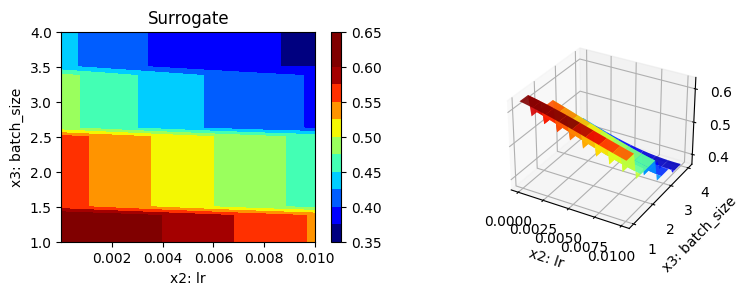

In [35]:
threshold = 0.025
impo = spot_tuner.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_tuner.y)
max_z = max(spot_tuner.y)
n = spot_tuner.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

## Parallel Coordinates Plot

In [36]:
spot_tuner.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [37]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)